<a href="https://colab.research.google.com/github/anirbanl/jax-code/blob/master/rlflax/jax_flax_gae_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install jax jaxlib flax

In [14]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import jax
import jax.numpy as jp
from jax.ops import index, index_add, index_update
from jax import jit, grad, vmap, random, jacrev, jacobian, jacfwd, value_and_grad
from functools import partial
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays
from flax import linen as nn           # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state
import optax                           # Optimizers
from typing import Sequence

In [15]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)


In [27]:
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return jp.array(x[:, None] == jp.arange(k), dtype)

def calculate_advantages(rewards, values, gamma, lamda):
    advantages = []
    advantage = 0
    next_value = 0
    
    for r, v in zip(reversed(rewards), reversed(values)):
        td_error = r + next_value * gamma - v
        advantage = td_error + advantage * gamma * lamda
        next_value = v
        advantages.insert(0, advantage)
    advantages = jp.array(advantages)
    advantages = (advantages - advantages.mean()) / advantages.std()
        
    return advantages

class Policy:
    def __init__(self, rng, s_size=4, a_size=2, lr=1e-3):
        super(Policy, self).__init__()
        self.key = rng

        class Actor(nn.Module):
            features: Sequence[int]

            @nn.compact
            def __call__(self, x):
                x = nn.Dense(self.features[0])(x)
                x = nn.Dense(self.features[1])(x)
                x = nn.Dense(self.features[2])(x)
                x = nn.softmax(x)
                return x

        self.actor = Actor(features=[128, 256, a_size])

        class Critic(nn.Module):
            features: Sequence[int]

            @nn.compact
            def __call__(self, x):
                x = nn.Dense(self.features[0])(x)
                x = nn.Dense(self.features[1])(x)
                x = nn.Dense(self.features[2])(x)
                return x

        self.critic = Critic(features=[128, 256, 1])

        def create_train_state(rng, model, learning_rate, s_size, a_size):
            """Creates initial `TrainState`."""
            params = model.init(rng, jp.ones((s_size, )))#['params']
            tx = optax.adam(learning_rate)
            return train_state.TrainState.create(
                apply_fn=model.apply, params=params, tx=tx)

        self.actor_ts = create_train_state(rng, self.actor, lr, s_size, a_size)
        self.critic_ts = create_train_state(rng, self.critic, lr, s_size, a_size)

        @jit
        def train_step(actor_ts, critic_ts, sar, gamma=1.0, lamda=0.99):
            """Train for a single step."""
            sar['r'] = jp.array(sar['r'])
            sar['s'] = jp.array(sar['s'])
            sar['a'] = jp.array(sar['a'])

            def loss_fn(actor_params, critic_params):
                one_hot_actions = one_hot(sar['a'], a_size)
                probs = actor_ts.apply_fn(actor_params, sar['s'])
                values = critic_ts.apply_fn(critic_params, sar['s'])
                advantage = calculate_advantages(sar['r'], values.reshape(sar['r'].shape), gamma, lamda)
                actor_loss = jp.einsum('ij,i->',- one_hot_actions * jp.log(probs), jax.lax.stop_gradient(advantage))
                critic_loss = jp.mean(advantage**2)
                return actor_loss, critic_loss

            actor_loss = lambda x: loss_fn(x, critic_ts.params)[0]
            critic_loss = lambda y: loss_fn(actor_ts.params, y)[1]
            al, ag = value_and_grad(actor_loss)(actor_ts.params)
            cl, cg = value_and_grad(critic_loss)(critic_ts.params)
            return actor_ts.apply_gradients(grads=ag), critic_ts.apply_gradients(grads=cg), al, cl

        self.train_fn = train_step


    def act(self, state):
        probs = self.actor_ts.apply_fn(self.actor_ts.params, state)
        self.key, _ = jax.random.split(self.key)
        uf = jax.random.uniform(self.key, (1,), minval=0.0, maxval=1.0)[0]
        action = jp.argmax(uf < jp.cumsum(probs))
        return action.item()


In [30]:
def train(env, policy, n_episodes=10000, max_t=1000, gamma=1.0, lamda=0.99, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        # print(f"Episode {i_episode}")
        saved_log_probs = []
        rewards = []
        sar = {key: [] for key in 'sar'}
        state = env.reset()
        # print(f'State:{state}')
        for t in range(max_t):
            action = policy.act(state)
            # print(f'Action:{action}')
            sar['s'].append(state)
            sar['a'].append(action)
            state, reward, done, _ = env.step(action)
            sar['r'].append(reward)
            rewards.append(reward)
            if done:
                # print(f'Done {t}')
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        policy.actor_ts, policy.critic_ts, al, cl = policy.train_fn(policy.actor_ts, policy.critic_ts, sar, gamma, lamda)
        # print(f'loss {l}')
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores

def plot_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: 2
Episode 100	Average Score: 88.10
Episode 200	Average Score: 164.72
Environment solved in 127 episodes!	Average Score: 195.16


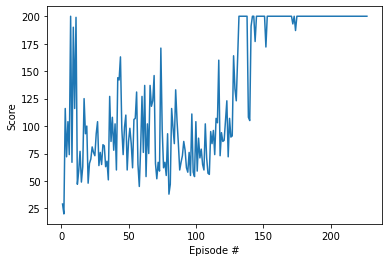

In [31]:
def main():
    env = gym.make('CartPole-v0')
    env.seed(0)
    print('observation space:', env.observation_space)
    print('action space:', env.action_space.n)
    rng = jax.random.PRNGKey(0)
    pi = Policy(rng, lr=1e-3)
    scores = train(env, pi)
    plot_scores(scores)

if __name__ == '__main__':
    main()